In [162]:
import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR
import itertools
from scipy import stats
from scipy.fftpack import dct
import matplotlib.pyplot as plt


class feature_engineering():
    
    # path - String, Path to data 
    # sliding_windows - Int, Number of sliding windows in rolling features (rolling mean/rolling std etc) 
    # target - String, Value in the data we wish to predict and optimise the model around.
    # train_length - Int, Number of datapoints to train on 
    # predict_length - Int, Number of datapoints to forecast
    
    def __init__(self, path, sliding_windows = 5, target = '', train_length = 168, predict_length = 24):
        self.path = path
        self.sliding_windows = sliding_windows
        self.target = target
        self.train_length = train_length
        self.predict_length = predict_length


        self.optimal_combination = None
        self.optimal_score = 100000000
        

        
    # Pull data from path
    def get_data(self):
        
        # Model currently uses 1 weeks data to predict the next day (24 hours)
        series = pd.read_csv(self.path)[:(self.train_length)*2 + (self.predict_length)*2 + (self.sliding_windows)*2 ]
  
        # sliding window parameters is added so there is always self.train_length datapoints to train on
        train = series[:self.train_length + self.predict_length + self.sliding_windows]
        test = series[self.train_length + self.predict_length + self.sliding_windows:]
       
        return train.reset_index(drop=True), test.reset_index(drop=True)

    
    
    # Generate features based on time of day/day of week/ month
    def date_feature(self, data):
            
        features = pd.DataFrame()
        
        # Hour of day feature
        features['hour'] = pd.to_datetime(data['Datetime']).dt.hour
        
        # Day of week feature
        features['day'] = pd.to_datetime(data['Datetime']).dt.dayofweek
        
        # Month of year feature
        features['month'] = pd.to_datetime(data['Datetime']).dt.month
        
        # Year feature
        features['year'] = pd.to_datetime(data['Datetime']).dt.year
        year_dict = { np.unique(features['year'])[i] : i for i in range(len(np.unique(features['year'])))}
        
        for index in features.index:
            year = features['year'][index]
            features['year'][index] = year_dict[year]
            
        return features


    # Create X/Y data splits given preset parameters
    def X_Y(self, data):
        # Data split takes into account the number of sliding windows. This means there will always be self.train_length
        # points to train on and self.predict_length points to predict. This matters when we are not using any extra
        # features. The split allows us to compare the accuracy over the same datapoints
        
        X = data[-(self.predict_length + self.train_length + self.sliding_windows):-self.predict_length].reset_index(drop=True)
        Y = data[-self.predict_length:][self.target].reset_index(drop=True)
        return X,Y
    

    # Mean absolute percentage error allowing for a more intuative understanding of errors 
    def mape(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


    
    # Create a boolean vector of outliers using Tukey's fences. 1 where outlier else 0
    def boolean_vector(self, data):
        # Find outlier index locations
        ones = self.outliers_iqr(data[self.target])
        vector = np.zeros(len(data))
        vector[ones] = 1
        vector = pd.DataFrame(vector)
        vector.columns = ['boolean_vector']
        return vector
        
        
    # Calculate outlier array indexs from bounds   
    def outliers_iqr(self, ys):
        quartile_1, quartile_3 = np.percentile(ys, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return np.where((ys > upper_bound) | (ys < lower_bound))
    
    
    
    # Create rolling mean feature
    def rolling_mean(self, data):
        item_to_predict = pd.DataFrame(data[self.target])
        rolling = item_to_predict.rolling(window =self.sliding_windows).mean()
        rolling.columns = ['rolling_mean']
        return rolling
    
    
    
    # Create rolling standard deviation vector
    def rolling_std(self, data):
        item_to_predict = pd.DataFrame(data[self.target])
        rolling = item_to_predict.rolling(window =self.sliding_windows).std()
        rolling.columns = ['rolling_std']
        return rolling
    
    
    # Create rolling variance vector
    def rolling_var(self, data):
        rolling_var = self.rolling_std(data)**2
        rolling_var.columns = ['rolling_var']
        return rolling_var
    
    
    
    # Create rolling median vector
    def rolling_median(self, data):
        item_to_predict = pd.DataFrame(data[self.target])
        rolling = item_to_predict.rolling(window =self.sliding_windows).median()
        rolling.columns = ['rolling_median']
        return rolling
    
    
    
    # Create rolling min vector
    def rolling_min(self, data):
        item_to_predict = pd.DataFrame(data[self.target])
        rolling = item_to_predict.rolling(window =self.sliding_windows).min()
        rolling.columns = ['rolling_min']
        return rolling

    
    
    # Create rolling max vector
    def rolling_max(self, data):
        item_to_predict = pd.DataFrame(data[self.target])
        rolling = item_to_predict.rolling(window =self.sliding_windows).max()
        rolling.columns = ['rolling_max']
        return rolling
    
    
    
    # Create percentile vector
    def percentile_vector(self, data):
        percentile_vector = []

        for v in data[self.target].values:
            percentile_vector.append(stats.percentileofscore(data[self.target].values, v))
            
        percentile_vector = pd.DataFrame(percentile_vector)
        percentile_vector.columns = ['percentile_vector']
        return percentile_vector.reset_index(drop=True)

    
    
    # Create discrete cosine tranform feature vector
    def discrete_cosine_transform(self, data):
        transform = pd.DataFrame(dct(data[self.target]))
        transform.columns = ['cosine_transform']
        return transform
    
    
    
    # Create fast fourier tranform feature vector
    def fast_fourier_transform(self, data):
        transform = pd.DataFrame(np.fft.fft(data[self.target]).real)
        transform.columns = ['fourier_transform']
        return transform
    
    
    
    
    # Check for vectors which are all the same value. These features will make no impact to the accuracy of our model.
    # EG: No oulier/ all in the same year. We then delete these columns.
    def check_for_constant(self, data):
        columns_to_delete = []

        # Iterate over all columns
        for col in data.columns:
            first_value = data[col][0]
            
            # boolean to check if the loop was broken from
            broken = False
            for elem in data[col][1:]:
                if elem != first_value:
                    broken = True
                    break
            # If the series values are all the same. Set this series to be ignored. It has no value.
            if not broken:
                columns_to_delete.append(col)

        return columns_to_delete
    
    
    
    # Optimise feature vectors on the training set
    def optimise(self, train, functions):
        
        functions = np.array(functions)
        
        # Reset optimal parameters
        self.optimal_combination = None
        self.optimal_score = 100000000

        
        # Check if the user wishes to fit a model without any extra features
        none = False
        if 'none' in functions:
            none = True
            functions = np.delete(functions, np.where(functions == 'none')[0][0])
            

                
        # No need to delete first few entries without rolling features
        if 'rolling_mean' not in functions and 'rolling_std' not in functions and 'rolling_var' not in functions and 'rolling_median' not in functions and 'rolling_min' not in functions and 'rolling_max' not in functions:
            self.sliding_windows = 0
        

        # Calculate all training/validation features
        train_features = {'data':train.drop(['Datetime'], axis=1)}
        
        
            
        # Iterate over desired features and calculate for each. These features are calculated once and stored in 
        # a dictionary for quick and easy access later
        for feature in functions:
            function = getattr(feature_engineering, feature)
            
            t_features = function(self, train)
                            
            if feature == 'date_feature':
                t_features.year = np.ones(len(t_features.year))
                
                
            columns_to_delete = self.check_for_constant(t_features)
             
            
            # Delete constants
            if len(columns_to_delete) > 0:
                print(feature, columns_to_delete,"ommited due to constant series.\n")
                
                # If the feature only has 1 variable. Drop it
                if len(t_features.columns) == 1:
                    functions = np.delete(functions, np.where(functions==feature)[0])
                    
                # Otherwise drop specific columns and append the rest to the dictionary
                else:
                    t_features = t_features.drop(np.array(columns_to_delete),axis=1)
                    train_features[feature] = t_features
                    
            # Otherwise append to dictionary. Data is ok.
            else:
                train_features[feature] = t_features
                
                
                
                
        # Find unique combination of features to optimise
        combinations = []
        for length in range(len(functions)):
            for comb in list(itertools.combinations(functions,length+1)):
                combinations.append(comb)
                
                
        # If no features are selected. Fit a univariate model using solely historical data.
        if none:
            
            comb_train_features = train_features['data']
            X_train, Y_train = self.X_Y(comb_train_features[self.sliding_windows:])
            
            
            if X_train.shape[1] > 1:
                # If we have more features than just previous energy in the dataset. EG: weather we need to use a multivariate model
                predictions = self.multivariate(X_train, len(Y_train))
            else:
                # Univariate model instead of multivariate used in other cases.
                predictions = self.univariate(X_train, len(Y_train))
                
            error = self.mape(Y_train, predictions)
            
            if error < self.optimal_score:
                self.optimal_score = error
                self.optimal_combination = 'none'
        
        
       # Iterate over unique combinations to find most optimal feature combination  
        for comb in combinations:
            
            
            # All combinations need the original data
            comb_train_features = train_features['data']
            
            
            # Concatenate the engineered features
            for c in comb:
                comb_train_features = pd.concat([comb_train_features, train_features[c]], axis=1)
                
            # Create data split for current combinations
            X_train, Y_train = self.X_Y(comb_train_features[self.sliding_windows:])
            
            # Try to fit model. Some models may not coverge. Catch these
            try:
                predictions = self.multivariate(X_train, len(Y_train))

                # Mean absolute error is used to optimise features
                error = self.mape(Y_train, predictions)
                

                if error < self.optimal_score:
                    self.optimal_score = error
                    self.optimal_combination = comb
        
            except Exception as e:
                print(e)
                print(comb,"failed.\n")
                continue
                
                
        # Create dataframe of optimal features
        optimal_features = train_features['data']
        
        # If no features are beneficial. Soley return the training window
        if self.optimal_combination == 'none':
            return optimal_features
        else:
            for feature in self.optimal_combination:
                optimal_features = pd.concat([optimal_features, train_features[feature]], axis=1)


            # Return optimal features    
            return optimal_features[self.sliding_windows:]
    
    
    # Fit and predict using univariate model
    def univariate(self, X, len_Y):
        model = AR(endog=X)
        model_fit = model.fit(maxlags=5)
        predictions = model_fit.predict(start = len(X), end= len(X)+len_Y-1)
        return pd.DataFrame(predictions).reset_index(drop=True)
    
    
    
    # Fit and predict using multivariate model
    def multivariate(self, X, len_Y):
        model = VAR(endog=X)
        model_fit = model.fit(maxlags=5)
        predictions = model_fit.forecast(model_fit.y, steps= len_Y)[:,0]
        return predictions
    
    

        
    
    # Fit new data using the optimal features and predict self.predict_length timesteps ahead.
    def fit_and_predict(self, data):
        print("Fitting new model with optimised features.\n")
        
        test_features = data.drop(['Datetime'], axis=1)
        
        # If no features are beneficial. Fit the univariate model to the test set.
        if self.optimal_combination == 'none':
            
            X_test, Y_test = self.X_Y(test_features[self.sliding_windows:])
            
            # Univariate model if there is only 1 variable and combination == 'none'
            if X_test.shape[1]>1:
                predictions = self.multivariate(X_test, len(Y_test))
            else:
                predictions = self.univariate(X_test, len(Y_test))
                
            return predictions, Y_test.reset_index(drop=True)
    
        else:
            # Create test feature set
            for feature in self.optimal_combination:
                function = getattr(feature_engineering, feature)


                t_features = function(self, data)
                # Check for constant values in new features
                columns_to_delete = self.check_for_constant(t_features)
                
                if len(columns_to_delete) > 0:
                    print(feature, columns_to_delete,"ommited due to constant series.\n")

                    # If the feature only has 1 variable. Ignore it. Otherwise drop specific columns
                    if len(t_features.columns) > 1:
                        t_features = t_features.drop(np.array(columns_to_delete),axis=1)
                        test_features = pd.concat([test_features, t_features], axis=1)

                # Otherwise append to dataframe. Data is ok.
                else:
                    test_features = pd.concat([test_features, t_features], axis=1)
                

            # Create X/Y for test set
            X_test, Y_test = self.X_Y(test_features[self.sliding_windows:])

            # Make predictions on the test set using the optimal pretrained model
            model = VAR(endog=X_test)
            model_fit = model.fit(maxlags=5)
            predictions = model_fit.forecast(model_fit.y, steps= len(Y_test))[:,0]
     
        print("Model fit and forecast of",self.predict_length,"datapoints computed.\n")
        return predictions, Y_test.reset_index(drop=True)

In [169]:
fe = feature_engineering(path = 'data/FE_hourly.csv',
                         # Number of sliding windows when using rolling features.
                         sliding_windows = 8,
                         # target vector in the data we want to predict
                         target = 'FE_MW',
                         # Number of datapoints to train on (1 week = 168)
                         train_length = 168,
                         # Number of datapoints to forecast (1 day = 24)
                         predict_length = 48)

# Get data
train, test = fe.get_data()

# Optimise feature combination on the training set
optimal_features = fe.optimise(train,
                               # Feature list
                              ['none', 'date_feature', 'boolean_vector', 'rolling_mean',
                               'rolling_std', 'rolling_var', 'percentile_vector',
                               'rolling_median', 'rolling_min', 'rolling_max',
                               'discrete_cosine_transform', 'fast_fourier_transform'])
 

print('Optimal features:',fe.optimal_combination,"\n")
print('Optimal error:',fe.optimal_score,"%\n")

# Test how well the features generalise on the test set
predictions, true = fe.fit_and_predict(test)


date_feature ['year'] ommited due to constant series.

boolean_vector ['boolean_vector'] ommited due to constant series.

Optimal features: ('date_feature', 'rolling_mean', 'rolling_std', 'percentile_vector', 'rolling_max', 'discrete_cosine_transform', 'fast_fourier_transform') 

Optimal error: 5.620833773462871 %

Fitting new model with optimised features.

date_feature ['month', 'year'] ommited due to constant series.

Model fit and forecast of 48 datapoints computed.



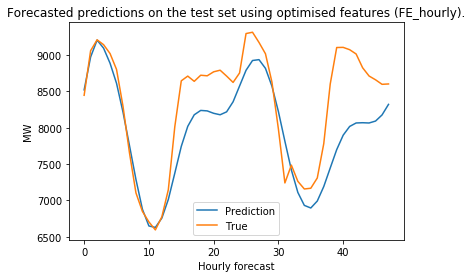

MAPE on the test set is 4.68 % using features: ('date_feature', 'rolling_mean', 'rolling_std', 'percentile_vector', 'rolling_max', 'discrete_cosine_transform', 'fast_fourier_transform')


In [170]:
plt.plot(predictions, label = 'Prediction')
plt.plot(true, label = 'True')
plt.xlabel("Hourly forecast")
plt.ylabel("MW")
plt.title("Forecasted predictions on the test set using optimised features.")
plt.legend()
plt.show()
print("MAPE on the test set is",round(fe.mape(true, predictions),2),"% using features:",fe.optimal_combination)

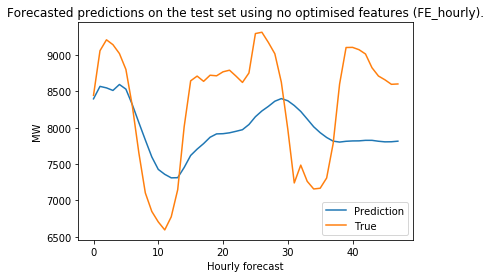

MAPE on the test set is 10.06 % using features: none


In [168]:
plt.plot(predictions, label = 'Prediction')
plt.plot(true, label = 'True')
plt.xlabel("Hourly forecast")
plt.ylabel("MW")
plt.title("Forecasted predictions on the test set using no optimised features.")
plt.legend()
plt.show()
print("MAPE on the test set is",round(fe.mape(true, predictions),2),"% using features:",fe.optimal_combination)